# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the phase-field model of solid-state transformations in additive superalloy 625, represented as a ternary (Mo-Nb-Ni) with γ, δ, and μ phases competing. The BCC phase is included for ternary isothermal phase diagram generation, only -- it is not used in simulations.

The phase field model requires Gibbs free energies as functions of system compositions $x_\mathrm{Mo}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad database, Thermotech Ni..., represents these energies as functions of sublattice compositions in each phase. To avoid solving for internal phase equilibrium at each point in the simulation, the following approximations have been made:
* γ: FCC (Mo,Nb,Ni) has only one sublattice, no changes necessary
* BCC: (Mo,Nb,Ni) has only one sublattice, no changes necessary
* δ:  two sublattices, approximately stoichiometric $\mathrm{(Nb,Ni)_3(Mo,Nb,Ni) \rightarrow Ni_3(Mo,Nb,Ni)}$
* μ: three sublattices $\mathrm{Ni'_6(Mo'',Nb'')_4(Mo''',Nb''',Ni''')_3 \rightarrow Ni'_6(Mo'',Nb'')_4(Mo'',Nb''',Ni''')_3}$, *viz.* the sublattice compositions of Mo are set equal, $y_\mathrm{Mo}'' = y_\mathrm{Mo}'''$. This allows for a unique mapping from sublattice $y$ to system $x$ composition. Phases such as this tend to have sharp Gibbs energies with cusp-like minima at the stoichiometric composition, and high energies far away. This approximation preserves the behavior near stoichiometry, but introduces high error far away -- a tolerable situation in our opinion.

In [1]:
%matplotlib inline
# Numerical libraries
import numpy as np
from scipy.optimize import fsolve
from sympy.utilities.lambdify import lambdify
from scipy.spatial import ConvexHull

# Runtime / parallel libraries
import time, warnings
from itertools import chain
from multiprocessing import Pool

# Thermodynamics and computer-algebra libraries
from pycalphad import Database, calculate, Model
from sympy.utilities.codegen import codegen
from sympy.parsing.sympy_parser import parse_expr
from sympy import And, diff, Gt, Lt, Piecewise, simplify, symbols, sympify

# Visualization libraries
import matplotlib.pylab as plt
from ipywidgets import FloatProgress
from IPython.display import display

# Constants
fr13by7 = 13.0/7
fr13by3 = 13.0/3
fr13by4 = 13.0/4
fr3by4 = 3.0/4
rt3by2 = np.sqrt(3.0)/2
epsilon = 1e-8 # tolerance for comparing floating-point numbers to zero
temp = 870.0 + 273.15 # 1143 Kelvin
#temp = 500.0 + 273.15 # kelvin

In [2]:
#tdb = Database('mc_ni_v2.033.tdb')
#tdb = Database('monbni-simple.tdb')
#tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC.tdb')
tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC_simple.tdb')

In [3]:
phases = ['FCC_A1', 'DELTA', 'MU_PHASE', 'BCC_A2', 'LIQUID']
elements = ['MO', 'NB', 'NI']

## Export Gibbs functions using SymPy

In [4]:
c_gamma = list(set([i for c in tdb.phases['FCC_A1'].constituents for i in c]))
m_gamma = Model(tdb, c_gamma, 'FCC_A1')
g_gamma = parse_expr(str(m_gamma.ast))

In [5]:
c_delta = list(set([i for c in tdb.phases['DELTA'].constituents for i in c]))
m_delta = Model(tdb, c_delta, 'DELTA')
g_delta = parse_expr(str(m_delta.ast))

In [6]:
c_mu = list(set([i for c in tdb.phases['MU_PHASE'].constituents for i in c]))
m_mu = Model(tdb, c_mu, 'MU_PHASE')
g_mu = parse_expr(str(m_mu.ast))

In [7]:
c_bcc = list(set([i for c in tdb.phases['BCC_A2'].constituents for i in c]))
m_bcc = Model(tdb, c_bcc, 'BCC_A2')
g_bcc = parse_expr(str(m_bcc.ast))

## Convert sublattice to phase composition (y to x)

In [8]:
# Declare sublattice variables used in Pycalphad expressions
FCC_A10MO, FCC_A10NB, FCC_A10NI, FCC_A11VA = symbols('FCC_A10MO FCC_A10NB FCC_A10NI FCC_A11VA')
DELTA0NI, DELTA0NB, DELTA1MO, DELTA1NB, DELTA1NI = symbols('DELTA0NI DELTA0NB DELTA1MO DELTA1NB DELTA1NI')
MU_PHASE0NI, MU_PHASE1MO, MU_PHASE1NB, MU_PHASE2MO, MU_PHASE2NB, MU_PHASE2NI = symbols('MU_PHASE0NI MU_PHASE1MO MU_PHASE1NB MU_PHASE2MO MU_PHASE2NB MU_PHASE2NI')
BCC_A20MO, BCC_A20NB, BCC_A20NI, BCC_A21VA = symbols('BCC_A20MO BCC_A20NB BCC_A20NI BCC_A21VA')
T = symbols('T')

# Declare system variables for target expressions
GAMMA_XMO, GAMMA_XNB, GAMMA_XNI = symbols('GAMMA_XMO GAMMA_XNB GAMMA_XNI')
DELTA_XMO, DELTA_XNB, DELTA_XNI = symbols('DELTA_XMO DELTA_XNB DELTA_XNI')
MU_XMO, MU_XNB, MU_XNI = symbols('MU_XMO MU_XNB MU_XNI')
BCC_XMO, BCC_XNB, BCC_XNI = symbols('BCC_XMO BCC_XNB BCC_XNI')

In [9]:
# Make substitutions
        
g_gamma = g_gamma.subs({FCC_A10MO: GAMMA_XMO,
                        FCC_A10NB: GAMMA_XNB,
                        FCC_A10NI: GAMMA_XNI,
                        FCC_A11VA: 1,
                        T: temp})

# Approximate delta as a stoichiometric compound, (Nb,Ni)3(Mo,Nb,Ni) ==> Ni3(Mo,Nb,Ni)
g_delta = Piecewise((g_delta.subs({DELTA0NI: 1.0,
                     DELTA0NB: 0,
                     DELTA1MO: 4.0*DELTA_XMO,
                     DELTA1NB: 4.0*DELTA_XNB,
                     DELTA1NI: 4.0*(DELTA_XNI-fr3by4),
                     T: temp}), \
                     Lt(DELTA_XMO+DELTA_XNB, 0.25)),
                    (0, True))

# Substitution made possible by setting y3_Mo=y4_Mo
g_mu = Piecewise((g_mu.subs({MU_PHASE0NI: 1.0,
                  MU_PHASE1NB: 1.0 - fr13by7*MU_XMO,
                  #MU_PHASE1NB: fr13by4*(MU_XNB-MU_XNI) + (39.0/28)*MU_XMO - 9.0/4,
                  MU_PHASE1MO: fr13by7*MU_XMO,
                  MU_PHASE2MO: fr13by7*MU_XMO,
                  MU_PHASE2NB: 3.0 - fr13by7*MU_XMO - fr13by3*MU_XNI,
                  MU_PHASE2NI: fr13by3*MU_XNI - 2.0,
                  T: temp}), \
                  And(Gt(3.0 - fr13by7*MU_XMO - fr13by3*MU_XNI,0.), Gt(fr13by3*MU_XNI,2.))),
                (0, True))

g_bcc = g_bcc.subs({BCC_A20MO: BCC_XMO,
                    BCC_A20NB: BCC_XNB,
                    BCC_A20NI: BCC_XNI,
                    BCC_A21VA: 1.0,
                    T: temp})

In [10]:
# Generate numerically efficient system-composition expressions
Gg = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
Gu = lambdify((MU_XMO, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

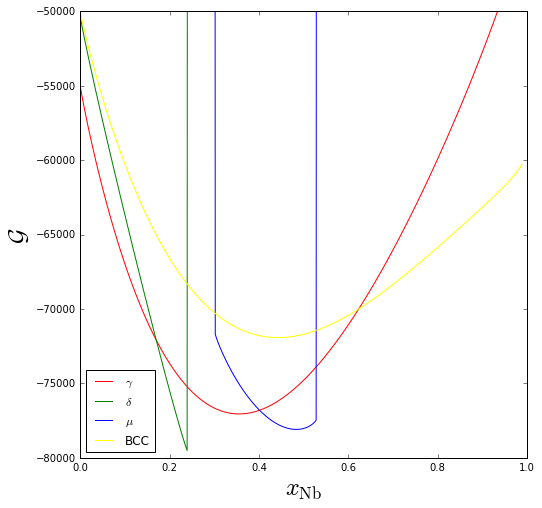

In [11]:
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'BCC']
colors = ['red', 'green','blue', 'yellow']

# plot Gibbs energy curves for fixed x_Mo = 1% to check mu stability
if True:
    xmo = 0.01
    X = []
    G = [[],[],[],[]]

    for xnb in np.linspace(epsilon,1,1001):
        xni = 1-xmo-xnb
        if xni>0:
            X.append(xnb)
            G[0].append(Gg(xmo,xnb,xni))
            G[1].append(Gd(xmo,xnb,xni))
            G[2].append(Gu(xmo,xnb,xni))
            G[3].append(Gb(xmo,xnb,xni))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    plt.ylim([-80000, -50000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

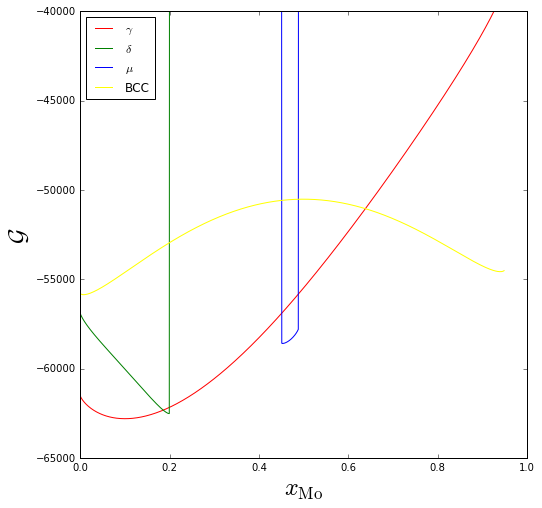

In [12]:
# plot Gibbs energy curves for fixed x_Nb = 5% to check delta stability
if True:
    xnb = 0.05
    X = []
    G = [[],[],[],[]]

    for xmo in np.linspace(epsilon,1,1001):
        xni = 1-xmo-xnb
        if xni>0:
            X.append(xmo)
            G[0].append(Gg(xmo,xnb,xni))
            G[1].append(Gd(xmo,xnb,xni))
            G[2].append(Gu(xmo,xnb,xni))
            G[3].append(Gb(xmo,xnb,xni))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Mo}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    plt.ylim([-65000, -40000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

## C output

In [13]:
# # Write Gibbs energy functions to disk, for direct use in phase-field code
# codegen([# Gibbs energies
#          ('g_gam',g_gamma), ('g_mu',g_mu), ('g_del',g_delta), ('g_bcc',g_bcc),
#          # First derivatives
#          ('dg_gam_dxMo',dGgam_dxMo), ('dg_gam_dxNb',dGgam_dxNb), ('dg_gam_dxNi',dGgam_dxNi),
#          ('dg_del_dxMo',dGdel_dxMo), ('dg_del_dxNb',dGdel_dxNb), ('dg_del_dxNi',dGdel_dxNi),
#          ('dg_mu_dxMo',dGmu_dxMo), ('dg_mu_dxNb',dGmu_dxNb), ('dg_mu_dxNi',dGmu_dxNi),
#          ('dg_bcc_dxMo',dGbcc_dxMo), ('dg_bcc_dxNb',dGbcc_dxNb), ('dg_bcc_dxNi',dGbcc_dxNi),
#          # Second derivatives
#          ('d2g_gam_dxMoMo',d2Ggam_dxMoMo), ('d2g_gam_dxMoNb',d2Ggam_dxMoNb), ('d2g_gam_dxMoNi',d2Ggam_dxMoNi), 
#         ('d2g_gam_dxNbNb',d2Ggam_dxNbNb), ('d2g_gam_dxNbMo',d2Ggam_dxNbMo), ('d2g_gam_dxNbNi',d2Ggam_dxNbNi), 
#         ('d2g_gam_dxNiNi',d2Ggam_dxNiNi), ('d2g_gam_dxNiMo',d2Ggam_dxNiMo), ('d2g_gam_dxNiNb',d2Ggam_dxNiNb), 
#          ('d2g_del_dxMoMo',d2Gdel_dxMoMo), ('d2g_del_dxMoNb',d2Gdel_dxMoNb), ('d2g_del_dxMoNi',d2Gdel_dxMoNi), 
#         ('d2g_del_dxNbNb',d2Gdel_dxNbNb), ('d2g_del_dxNbMo',d2Gdel_dxNbMo), ('d2g_del_dxNbNi',d2Gdel_dxNbNi), 
#         ('d2g_del_dxNiNi',d2Gdel_dxNiNi), ('d2g_del_dxNiMo',d2Gdel_dxNiMo), ('d2g_del_dxNiNb',d2Gdel_dxNiNb), 
#          ('d2g_mu_dxMoMo', d2Gmu_dxMoMo), ('d2g_mu_dxMoNb', d2Gmu_dxMoNb), ('d2g_mu_dxMoNi', d2Gmu_dxMoNi), 
#         ('d2g_mu_dxNbNb', d2Gmu_dxNbNb), ('d2g_mu_dxNbMo', d2Gmu_dxNbMo), ('d2g_mu_dxNbNi', d2Gmu_dxNbNi), 
#         ('d2g_mu_dxNiNi', d2Gmu_dxNiNi), ('d2g_mu_dxNiMo', d2Gmu_dxNiMo), ('d2g_mu_dxNiNb', d2Gmu_dxNiNb), 
#          ('d2g_bcc_dxMoMo',d2Gbcc_dxMoMo), ('d2g_bcc_dxMoNb',d2Gbcc_dxMoNb), ('d2g_bcc_dxMoNi',d2Gbcc_dxMoNi), 
#         ('d2g_bcc_dxNbNb',d2Gbcc_dxNbNb), ('d2g_bcc_dxNbMo',d2Gbcc_dxNbMo), ('d2g_bcc_dxNbNi',d2Gbcc_dxNbNi), 
#         ('d2g_bcc_dxNiNi',d2Gbcc_dxNiNi), ('d2g_bcc_dxNiMo',d2Gbcc_dxNiMo), ('d2g_bcc_dxNiNb',d2Gbcc_dxNiNb)],
#         language='C', prefix='energy625', project='ALLOY625', to_files=True)

# Generate a phase diagram

## Numerically efficient expressions

In [14]:
# # Gibbs energies are already done, ahead of binary Gibbs energy plots
            
# # First derivatives
# dgdx0 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxMo, modules='numpy')
# dgdx1 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNb, modules='numpy')
# dgdx2 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNi, modules='numpy')

# dddx0 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxMo, modules='numpy')
# dddx1 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNb, modules='numpy')
# dddx2 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNi, modules='numpy')

# dudx0 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxMo, modules='numpy')
# dudx1 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNb, modules='numpy')
# dudx2 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNi, modules='numpy')

# dbdx0 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxMo, modules='numpy')
# dbdx1 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNb, modules='numpy')
# dbdx2 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNi, modules='numpy')

# # Second derivatives
# d2gdxMoMo = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxMoMo, modules='numpy')
# d2gdxMoNb = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxMoNb, modules='numpy')
# d2gdxMoNi = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxMoNi, modules='numpy')

# d2gdxNbMo = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNbMo, modules='numpy')
# d2gdxNbNb = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNbNb, modules='numpy')
# d2gdxNbNi = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNbNi, modules='numpy')

# d2gdxNiMo = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNiMo, modules='numpy')
# d2gdxNiNb = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNiNb, modules='numpy')
# d2gdxNiNi = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNiNi, modules='numpy')


# d2ddxMoMo = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxMoMo, modules='numpy')
# d2ddxMoNb = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxMoNb, modules='numpy')
# d2ddxMoNi = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxMoNi, modules='numpy')

# d2ddxNbMo = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNbMo, modules='numpy')
# d2ddxNbNb = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNbNb, modules='numpy')
# d2ddxNbNi = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNbNi, modules='numpy')

# d2ddxNiMo = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNiMo, modules='numpy')
# d2ddxNiNb = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNiNb, modules='numpy')
# d2ddxNiNi = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNiNi, modules='numpy')


# d2udxMoMo = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxMoMo, modules='numpy')
# d2udxMoNb = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxMoNb, modules='numpy')
# d2udxMoNi = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxMoNi, modules='numpy')

# d2udxNbMo = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNbMo, modules='numpy')
# d2udxNbNb = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNbNb, modules='numpy')
# d2udxNbNi = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNbNi, modules='numpy')

# d2udxNiMo = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNiMo, modules='numpy')
# d2udxNiNb = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNiNb, modules='numpy')
# d2udxNiNi = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNiNi, modules='numpy')


# d2bdxMoMo = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxMoMo, modules='numpy')
# d2bdxMoNb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxMoNb, modules='numpy')
# d2bdxMoNi = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxMoNi, modules='numpy')

# d2bdxNbMo = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNbMo, modules='numpy')
# d2bdxNbNb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNbNb, modules='numpy')
# d2bdxNbNi = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNbNi, modules='numpy')

# d2bdxNiMo = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNiMo, modules='numpy')
# d2bdxNiNb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNiNb, modules='numpy')
# d2bdxNiNi = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNiNi, modules='numpy')

## Solver
Using scipy.spatial.ConvexHull, an interface to qhull

In [15]:
# triangle bounding the Gibbs simplex
XS = [0.0, 1.0, 0.5, 0.0]
YS = [0.0, 0.0,rt3by2, 0.0]
# triangle bounding three-phase coexistence
XT = [0.25, 0.4875+0.025/2,0.5375+0.4625/2, 0.25]
YT = [0.0,  0.025*rt3by2, 0.4625*rt3by2, 0.0]

In [16]:
def computeKernelExclusive(n):
    r = n / density
    xnb = (r + epsilon) / (density-1)
    s = n - r * density
    xmo = (s + epsilon) / (density-1)
    xni = 1 - xmo - xnb

    result = [0]*7
    
    if xni>0:
        result[0] = xmo
        result[1] = xnb
        result[2] = xni
        result[3] = Gg(xmo,xnb,xni)
        result[4] = Gd(xmo,xnb,xni)
        result[5] = Gu(xmo,xnb,xni)
        result[6] = Gb(xmo,xnb,xni)
    
    return result

In [17]:
density = 751
allMo = []
allNb = []
allG = []
allID = []
points = []
phases = []

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0,max=density**2) #(density-1)/2) 
    display(bar)

    pool = Pool(6)

    i = 0
    for result in pool.imap(computeKernelExclusive, range(density**2)):
        xmo, xnb, xni, fg, fd, fu, fb = result
        #xmo, xnb, xni, fd, fu, fb = result
        f = (fg, fd, fu, fb)
        #f = (fd, fu, fb)

        # Accumulate (x, y, G) points for each phase
        if (fd**2 + fu**2 + fb**2) > epsilon:
            for n in range(len(f)):
                allMo.append(rt3by2*xmo)
                allNb.append(xnb+xmo/2)
                allG.append(f[n])
                allID.append(n)
        i += 1
        bar.value = i

    pool.close()
    
    points = np.array([allMo, allNb, allG]).T
    
    hull = ConvexHull(points)
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:6m:50s elapsed


In [18]:
# Prepare arrays for plotting
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'BCC']
colors = ['red', 'green','blue', 'yellow']
X = [[],[],[],[]]
Y = [[],[],[],[]]
tielines = []
trilines = []

for simplex in hull.simplices:
    for i in simplex:
        X[allID[i]].append(allNb[i])
        Y[allID[i]].append(allMo[i])
        for j in simplex:
            if allID[i]==allID[j]:
                pass
            tielines.append([[allNb[i], allNb[j]],
                             [allMo[i], allMo[j]]])

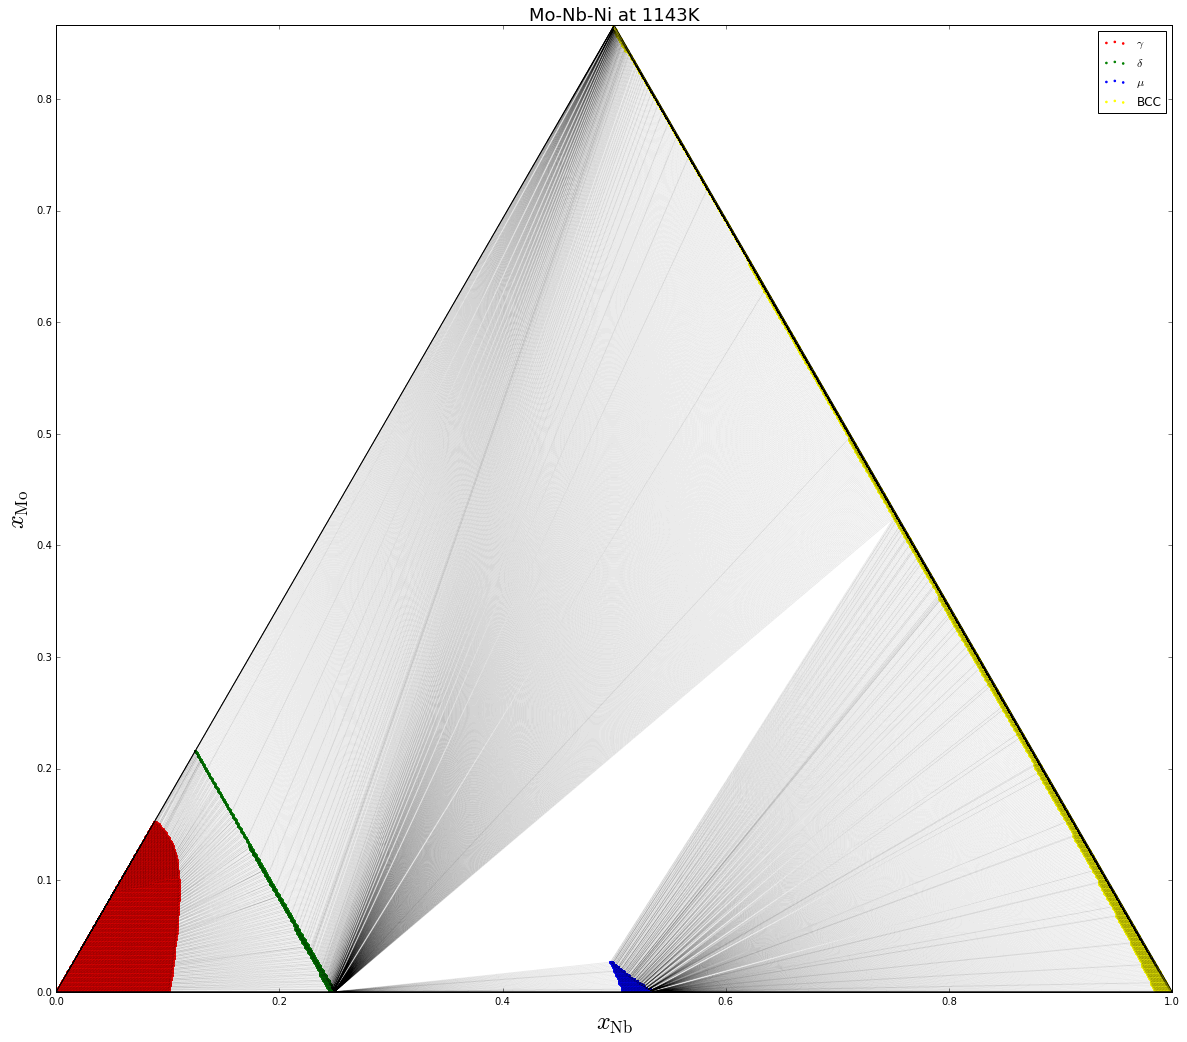

In [19]:
# Plot phase diagram
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Mo-Nb-Ni at %.0fK"%temp, fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Mo}$', fontsize=24)
plt.plot(XS, YS, '-k')
for tie in tielines:
    plt.plot(tie[0], tie[1], '-k', alpha=0.02)
for i in range(len(labels)):
    plt.scatter(X[i], Y[i], color=colors[i], s=2.5, label=labels[i])
plt.legend(loc='best')
plt.show()